# Descenso por gradiente en dos dimensiones

El descenso por gradiente es un algoritmo de optimización ampliamente utilizado para encontrar el mínimo local de una función diferenciable. Es especialmente fundamental en el campo del aprendizaje automático, donde se utiliza para minimizar una función de pérdida que mide el error de un modelo en función de sus parámetros.

El algoritmo se basa en el principio de que si la función es diferenciable en un punto, la dirección del gradiente en ese punto indica la dirección de mayor aumento. Por lo tanto, para encontrar un mínimo, se debe avanzar en la dirección opuesta al gradiente.

$$W_{\text{new}} = W_{\text{old}} - \eta \nabla_W \mathcal{L}$$

donde $\mathcal{L}$ es la función objetivo (función de pérdida en prendizaje), $\eta$ la tasa de aprendizaje y $W$ los parámetros de la función.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
import nni


### Función de Beale

La función de Beale es una función de prueba comúnmente utilizada en la optimización para evaluar el rendimiento de algoritmos en problemas no convexos. Es especialmente útil para probar algoritmos de optimización debido a su complejo paisaje, que presenta múltiples mínimos locales y un mínimo global único.

$$
f(x, y) = (1.5 - x + xy)^2 + (2.25 - x + xy^2)^2 + (2.625 - x + xy^3)^2
$$

Características

- Dominio: La función generalmente se evalúa en el rango de $( -4.5 \leq x, y \leq 4.5 )$, aunque este puede variar según el contexto específico.
- Mínimo Global: El mínimo global de la función de Beale se encuentra en $( x = 3 ) y ( y = 0.5 )$, donde $( f(3, 0.5) = 0 )$. Este es el único punto en el que la función alcanza un valor de cero.
- Complejidad: La función de Beale es desafiante para optimizar debido a su superficie curva y ondulada que posee múltiples mínimos locales. Esto hace que sea fácil para los algoritmos de optimización quedarse atrapados en un mínimo local en lugar de alcanzar el mínimo global.



In [2]:
f = nni.beale_function
df_dx = nni.beale_gradient_x
df_dy = nni.beale_gradient_y

# Search space
min_x = -4.5
max_x = 4.5
min_y = -4.5
max_y = 4.5

x = np.linspace(min_x, max_x, 100)
y = np.linspace(min_y, max_y, 100)

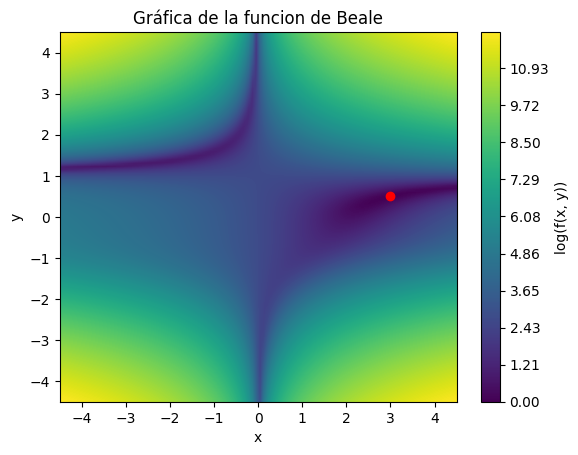

In [3]:
# Create a meshgrid of x and y values
X, Y = np.meshgrid(x, y)

# Calculate the corresponding z values using the function f
Z = f(X, Y)
# Applying a logarithmic transformation to Z values
Z_log = np.log(Z + 1)  # Adding 1 to avoid taking log of zero

# Create a 2D plot of the function
plt.contourf(X, Y, Z_log, levels=1000, cmap='viridis')
plt.plot(3, 0.5, 'ro')
plt.colorbar().set_label('log(f(x, y))')
#plt.colorbar()

# Add labels and title to the plot
plt.xlabel('x')
plt.ylabel('y')
plt.title('Gráfica de la funcion de Beale')


# Show the plot
plt.show()

In [4]:
class Optimizer:
    def __init__(self, tolerance=1e-5):
        self.tolerance = tolerance
        self.history = []

class GradientDescentOptimizer(Optimizer):
    def __init__(self, learning_rate=0.01, max_iterations=1000, tolerance=1e-5):
        super().__init__(tolerance=tolerance)
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations

    def next_params(self, gradient, params):
        return [param - self.learning_rate * grad for param, grad in zip(params, gradient)]
    
    def optimize(self, function, gradient, initial_params):
        self.history = []
        params = initial_params
        iteration = 0

        while iteration < self.max_iterations:
            log = {'iter': iteration, 'params': params, 'value': function(*params)}
            self.history.append(log)

            gradient_values = gradient(*params)
            updated_params = self.next_params(gradient_values, params)
            if self._converged(params, updated_params):
                break
            params = updated_params
            iteration += 1
        return params
    
    def _converged(self, params, updated_params):
        return all(abs(param - updated_param) < self.tolerance for param, updated_param in zip(params, updated_params))
    
    def get_history(self):
        return self.history
    

In [10]:
# -- hyperparameters --
# Initial guess
initial_params = [-1, -1.0]
# Learning rate
learning_rate = 0.01
# Maximum number of iterations
max_iterations = 300

In [11]:
optimizer = GradientDescentOptimizer(learning_rate=learning_rate, max_iterations=max_iterations, tolerance=1e-6)

# Optimize the function
optimized_params = optimizer.optimize(f, lambda x, y: [df_dx(x, y), df_dy(x, y)], initial_params)

print(f'Optimized parameters: {optimized_params}')
print(f'Optimized function value: {f(*optimized_params)}')

Optimized parameters: [2.7877178064757824, 0.44182052361845764]
Optimized function value: 0.009221975427812494


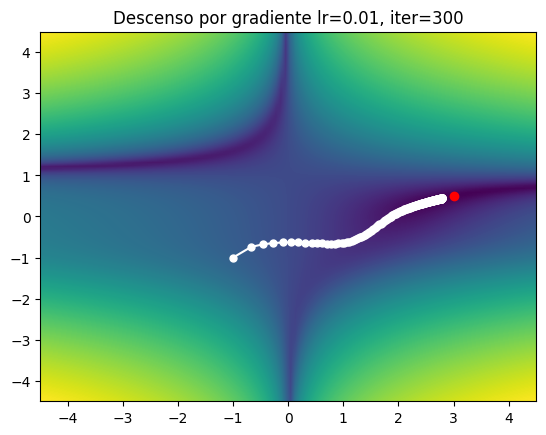

In [12]:
# Extract the x and y values from the history variable
history = optimizer.get_history()
x_values = [log['params'][0] for log in history]
y_values = [log['params'][1] for log in history]

# Create a 2D plot of the function
plt.contourf(X, Y, Z_log, levels=1000, cmap='viridis')
plt.plot(3, 0.5, 'ro')
plt.plot(x_values, y_values, 'w.-', markersize=10)
plt.title(f'Descenso por gradiente lr={optimizer.learning_rate}, iter={len(history)}')
plt.show()

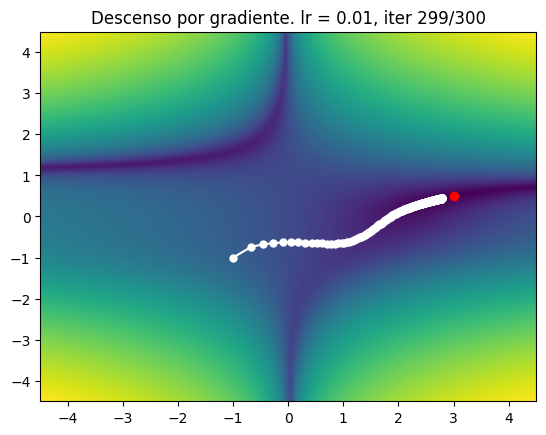

In [13]:
#Animate and save the optimization process
fig, ax = plt.subplots()
contour = ax.contourf(X, Y, Z_log, levels=1000, cmap='viridis')
points = ax.scatter(x_values[0], y_values[0], c='w', s=10)

# Function to update the plot for each frame
def update(frame):
    # Clear the previous plot
    ax.cla()
    
    # Create a new contour plot
    contour = ax.contourf(X, Y, Z_log, levels=1000, cmap='viridis')
    plt.plot(3, 0.5, 'ro')
    if frame > 0:
        # Plot the optimization path
        points = ax.plot(x_values[:frame], y_values[:frame], 'w.-', markersize=10)
    else:
        points = ax.scatter(x_values[:frame], y_values[:frame], c='w', s=10)
    # Update the title for each frame
    ax.set_title(f'Descenso por gradiente. lr = {optimizer.learning_rate}, iter {frame}/{len(x_values)}')

    return (contour, points)
    
# Create the animation
animation.FuncAnimation(fig, update, frames=len(x_values), interval=30).save('gradient_descent.gif', writer='imagemagick', fps=20)


## Momentum optimizer

In [ ]:
class MomentumOptimizer(GradientDescentOptimizer):
    def __init__(self, learning_rate=0.01, max_iterations=1000, tolerance=1e-6, beta=0.9):
        super().__init__(learning_rate=learning_rate, max_iterations=max_iterations, tolerance=tolerance)
        self.beta = beta

    def next_params(self, gradient, params):
        if not hasattr(self, 'momentum'):
            self.momentum = [0] * len(params)
        self.momentum = [self.beta * m + (1 - self.beta) * grad for m, grad in zip(self.momentum, gradient)]
        return [param - self.learning_rate * mom for param, mom in zip(params, self.momentum)]
        

In [ ]:
optimizer = MomentumOptimizer(learning_rate=0.005, max_iterations=100, tolerance=1e-6)

# Optimize the function
optimized_params = optimizer.optimize(f, lambda x, y: [df_dx(x, y), df_dy(x, y)], initial_params)

# Extract the x and y values from the history variable
history = optimizer.get_history()
x_values = [log['params'][0] for log in history]
y_values = [log['params'][1] for log in history]

# Create a 2D plot of the function
plt.contourf(X, Y, Z_log, levels=1000, cmap='viridis')
plt.plot(x_values, y_values, 'c.', markersize=10)
plt.show()